In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Import raw data
diabetes = pd.read_csv('diabetes_prediction_dataset.csv')
diabetes.loc[diabetes['diabetes'] == 1]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
6,Female,44.0,0,0,never,19.31,6.5,200,1
26,Male,67.0,0,1,not current,27.32,6.5,200,1
38,Male,50.0,1,0,current,27.32,5.7,260,1
40,Male,73.0,0,0,former,25.91,9.0,160,1
53,Female,53.0,0,0,former,27.32,7.0,159,1
...,...,...,...,...,...,...,...,...,...
99935,Female,65.0,1,1,never,33.55,8.2,140,1
99938,Male,55.0,0,1,former,30.42,6.2,300,1
99957,Female,61.0,0,0,No Info,34.45,6.5,280,1
99962,Female,58.0,1,0,never,38.31,7.0,200,1


In [3]:
# Print the first 6 rows
print(diabetes.head(6))

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   
5  Female  20.0             0              0           never  27.32   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
5          6.6                   85         0  


In [4]:
# Basic information of the dataset
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


The output indicates that the dataset has no missing value.

In [5]:
# Extracting numerical features
num_cols = diabetes.drop(columns = ['diabetes']).select_dtypes(exclude = ['bool', 'object']).columns # drop 'diabetes because it's the feature
print(num_cols)

# Extracting categorical features
cat_cols = diabetes.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level'],
      dtype='object')
Index(['gender', 'smoking_history'], dtype='object')


In [6]:
# Summary statistics for nummerical columns
print(diabetes.describe())

                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           14

### Data Cleaning

1. If duplications exist in our dataset, we would like to remove them

In [7]:
## Counting duplicated records
duplicates_num = diabetes.duplicated(keep = False).sum()
print("The number of duplicates in the data set is: ", duplicates_num)


The number of duplicates in the data set is:  6939


In [8]:
# Dropping duplicates
diabetes = diabetes.drop_duplicates()

2. The categories 'Other' in the feature 'gender' and 'No Info' in the feature 'smoking_history' may not be useful for our analysis, we would like to remove them.

In [9]:
# Relative frequency for the feature 'gender'
print((diabetes['gender'].value_counts()*100/len(diabetes)).round(2))

gender
Female    58.41
Male      41.57
Other      0.02
Name: count, dtype: float64


In [10]:
# Relative frequency for the feature 'smoking_history'
print((diabetes['smoking_history'].value_counts()*100/len(diabetes)).round(2))

smoking_history
never          35.78
No Info        34.21
former          9.67
current         9.57
not current     6.62
ever            4.16
Name: count, dtype: float64


Since the group 'Other' represents only 0.02% of our dataset, we can exclude all rows where the value 'Other' appears in the 'gender' column.

In [11]:
diabetes_cleaned = diabetes[diabetes['gender'] != 'Other']

The 'gender' column is now binary, we would like to convert it to an integer feature.

In [12]:
diabetes_cleaned['gender'] = diabetes_cleaned['gender'].map({'Male': '1', 'Female': '0'})

C:\Users\hddhx\AppData\Local\Temp\ipykernel_4164\443221421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_cleaned['gender'] = diabetes_cleaned['gender'].map({'Male': '1', 'Female': '0'})


The 'No info' value in the 'smoking_history' column accounts for 34.21% of our data, we need to remove the entire feature instead.

In [13]:
diabetes_cleaned = diabetes_cleaned.drop(columns = ['smoking_history'])

In [14]:
# The shape of our cleaned data
print('The shape of the cleaned dataset is:', diabetes_cleaned.shape)

The shape of the cleaned dataset is: (96128, 8)


### Exploring class imbalnce

In [15]:
print("The relative frequency of each class in the target:")
relative_frequency = (diabetes_cleaned[['diabetes']].value_counts() * 100 / len(diabetes_cleaned)).round(2)
print(relative_frequency)

The relative frequency of each class in the target:
diabetes
0           91.18
1            8.82
Name: count, dtype: float64


The dataset in severly imbalanced with the majority class being negative (92%). Does additional performance metrics such as f1-score is essential during the model evaluation phase.

### Preprocessing data for modelling

In [16]:
# Define features and label
X = diabetes_cleaned.drop(columns = ['diabetes'])
y = diabetes_cleaned['diabetes']

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('The shape of the training features: ', X_train.shape)
print('The shape of the training target: ', y_train.shape)
print('The shape of the testing features: ', X_test.shape)
print('The shape of the training target: ', y_test.shape)

The shape of the training features:  (76902, 7)
The shape of the training target:  (76902,)
The shape of the testing features:  (19226, 7)
The shape of the training target:  (19226,)


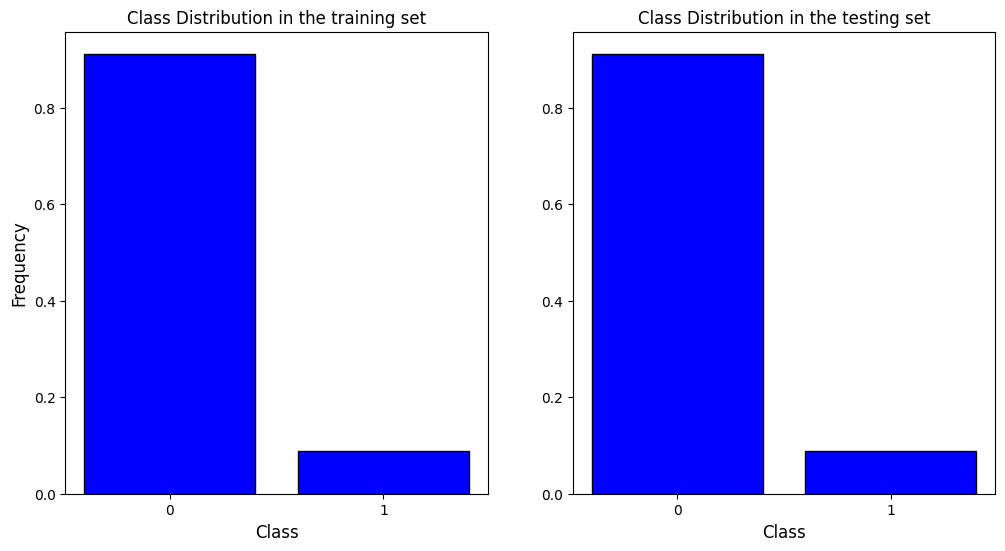

In [17]:
# Exploring the distribution of the target in both the training and testing set
# Convert data to relative frequency
y_train_counts = np.bincount(y_train) / len(y_train)  # Relative frequency for y_train
y_test_counts = np.bincount(y_test) / len(y_test)    # Relative frequency for y_test

# Create a figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for y_train
axes[0].bar([0, 1], y_train_counts, color='blue', edgecolor='black')
axes[0].set_title("Class Distribution in the training set")
axes[0].set_xlabel("Class", fontsize = 12)
axes[0].set_ylabel("Frequency", fontsize = 12)
axes[0].set_xticks([0, 1]) 

# Plot histogram for y_test
axes[1].bar([0, 1], y_test_counts, color = 'blue', edgecolor='black')
axes[1].set_title("Class Distribution in the testing set")
axes[1].set_xlabel("Class", fontsize = 12)
axes[1].set_xticks([0, 1])

The class distribution is consistent across training and testing dataset.

In [18]:
# Feature scaling
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


### Logistic Regression and Feature Selection

In [19]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [20]:
#Evaluation on training and testing data: accuracy and f1-score
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.96
f1-score score testing data: 0.72
Accuracy score training data: 0.96
f1-score score training data: 0.73


In [21]:
# Confusuin matrix
print("The confusion matrix for this logistic regression model is: ")
print(confusion_matrix(y_test, y_pred))

The confusion matrix for this logistic regression model is: 
[[17351   174]
 [  656  1045]]


It seems that most of the misclassifed instances belong to the False Positive category.

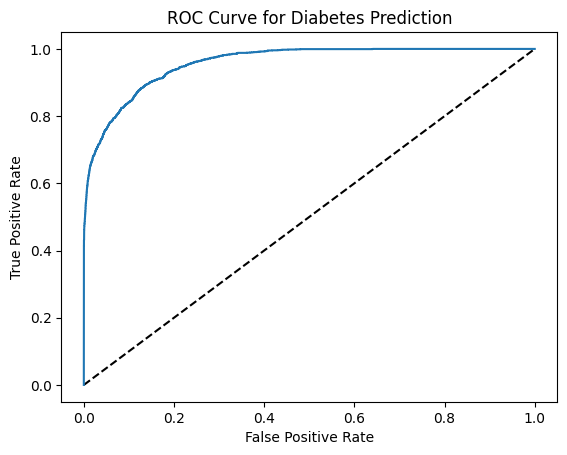

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0,80.0,0,1,25.19,6.6,140
1,0,54.0,0,0,27.32,6.6,80
2,1,28.0,0,0,27.32,5.7,158
3,0,36.0,0,0,23.45,5.0,155
4,1,76.0,1,1,20.14,4.8,155
...,...,...,...,...,...,...,...
99994,0,36.0,0,0,24.60,4.8,145
99996,0,2.0,0,0,17.37,6.5,100
99997,1,66.0,0,0,27.83,5.7,155
99998,0,24.0,0,0,35.42,4.0,100


In [22]:
# ROC curve

# Predict probabilities
y_pred_probs = logreg.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()
X

In [23]:
accuracy_scores = []
f1_scores = []
for i in range(1, X_train.shape[1]+1):
    rfe = RFE(estimator=logreg, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

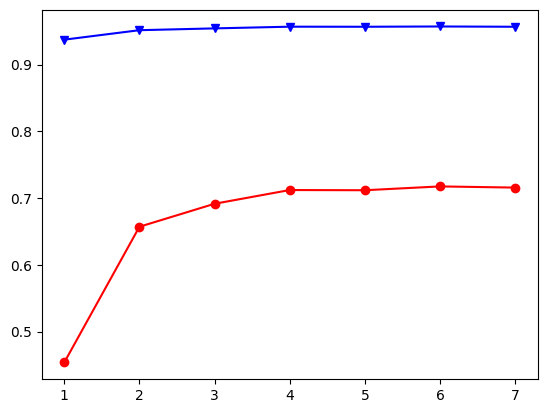

In [24]:
plt.plot(np.arange(1, X_train.shape[1]+1), f1_scores, label = 'fi_scores', color = 'r', marker = 'o')
plt.plot(np.arange(1, X_train.shape[1]+1), accuracy_scores, label = 'fi_scores', color = 'b', marker = 'v')

All features are retained after recursive feature elimination.

### Neural network for binary classification


### Decision Tree Classifer

In [25]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
print(diabetes.loc[75304])
X_train


gender                  Male
age                     65.0
hypertension               1
heart_disease              1
smoking_history        never
bmi                    28.49
HbA1c_level              8.8
blood_glucose_level      145
diabetes                   1
Name: 75304, dtype: object


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
39756,0,-1.501708,-0.288793,-0.206118,-1.686520,-1.895434,-1.178336
75304,1,1.032334,3.462687,4.851595,0.175549,3.039956,0.165844
19765,1,0.987877,3.462687,-0.206118,0.944633,-0.684866,-1.422733
97291,1,0.321024,-0.288793,-0.206118,-0.807990,-0.498625,-0.200751
37660,0,-0.701484,-0.288793,-0.206118,-0.791721,0.153219,0.483559
...,...,...,...,...,...,...,...
6284,0,-1.323880,-0.288793,-0.206118,-0.997303,0.432580,0.532439
56192,0,-0.479200,-0.288793,-0.206118,-0.438239,-0.964228,-1.300535
79371,0,1.210161,-0.288793,-0.206118,0.208087,0.432580,-1.178336
860,0,-0.212459,-0.288793,-0.206118,-0.346540,0.618822,0.483559


In [26]:
y_pred = dt_clf.predict(X_test)
y_pred_train = dt_clf.predict(X_train)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.95
f1-score score testing data: 0.71
Accuracy score training data: 1.00
f1-score score training data: 0.99


Without regularising the maximum depth of the tree, the model tends to overfit the data. We will use gridsearch cross-validation to find the optimal maximum depth.

In [27]:
param_max_depth = {'max_depth': np.arange(2, 15, 1).tolist()}
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_max_depth,
    scoring='f1',       # Metric to optimize (e.g., 'accuracy', 'f1')
    cv=5,                   # Number of cross-validation folds             
    n_jobs=-1               # Number of parallel jobs (-1 uses all CPUs)
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation f1-score: {grid_search.best_score_:.2f}")

Best parameters: {'max_depth': 9}
Best cross-validation f1-score: 0.81


In [28]:
# Extracting the best model and evaluate its performance
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.97
f1-score score testing data: 0.79
Accuracy score training data: 0.97
f1-score score training data: 0.81


In [29]:
# Confusuin matrix
print("The confusion matrix for this decision tree classification model is: ")
print(confusion_matrix(y_test, y_pred))

The confusion matrix for this decision tree classification model is: 
[[17506    19]
 [  581  1120]]


In [30]:
import pickle
with open('diabetes.pkl', 'wb') as f:
  pickle.dump(best_model, f)